# Лабораторная №3. Снижение размерности признакового пространства методом главных компонент.

## 1. Обработка данных
Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

#%matplotlib inline # авто вывод графиков (отпадает необходимость писать plt.show())

 Указываем названия выбранных признаков

In [2]:
features =["X6", "X16", "X26", "X31", "X39"] 
#в переменную f_len записываем кол-во признаков x1 , x2 , x3 , x4 , x5
f_len = len(features) 

X1 - удельный вес население в трудостпособном возрасте (%);
<br>
X13 - обеспеченность населения врачами (на 10000 человек);
<br>
X23 - площадь жилищ, приходящаяся в среднем на одного жителя (кв.м.);
<br>
X41 - число предприятий обрабатывающего производства;
<br>
X48 - объем платных услуг на душу населения (рублей).


Считываем данные

In [3]:
data = pd.read_excel(r'C:\Games\Ekonometrika\data_for_3_and_4.xlsx').loc[:,features]
data.head()

X6   X16   X26   X31  X39
NaN Абдулинский      53.69  93.1  42.3  33.9  0.2
    Адамовский       62.31  23.4  63.6  16.7  3.6
    Акбулакский      62.71  23.6  43.7  16.8  3.9
    Александровский  61.69  46.7  41.5  10.4  4.2
    Асекеевский      59.44  44.0  79.3  26.4  4.1

Поскольку исходные признаки отличаются масштабом измерения, то будем рассматривать вектор центрировано-нормированных признаков x* = (x1*, x2*,…, xk*)T и на основе исходной матрицы данных X рассчитаем оценку корреляционной матрицы 𝑅̂𝑥. 

Объекты, для которых значения хотя бы одного признака отсутствуют, исключены из рассмотрения. 

Также, для последующей работы, создадим dataframe на основании полученных данных

In [4]:
data_cleared = data[data!='-'].dropna().astype('float64') # для которых нет значений, удаляем, потом центрируем и нормируем
index = data_cleared.index #записываем в переменную index названия строк исходной матрицы
columns = data_cleared.columns #записываем в переменную columns названия столбцов исходной матрицы

scaled = (data_cleared - data_cleared.mean(axis=0))/data_cleared.std() #стандартизируем данные: вычитаем среднее и делим на стандартное отклонение

#создаем датафрейм из scaled со столбцами columns и индексами index
scaled_data = pd.DataFrame(scaled, columns=columns, index=index) 

scaled_data.head()

X6       X16       X26       X31       X39
NaN Абдулинский     -2.579260  2.914943 -0.481479  1.817417 -2.376303
    Адамовский       0.247940 -1.084664  0.568420 -0.153341 -0.542729
    Акбулакский      0.379133 -1.073188 -0.412472 -0.141883 -0.380943
    Александровский  0.044592  0.252364 -0.520912 -0.875188 -0.219157
    Асекеевский     -0.693367  0.097429  1.342290  0.958075 -0.273085

Выведем оставшиеся в выборке объекты:

In [5]:
print('Было {} объектов,стало {}'.format(data.shape[0],scaled_data.shape[0]))

Было 47 объектов,стало 47


### 2. Корреляционная матрица


Для расчета коэффициентов корреляции между каждой парой признаков воспользуемся стандартным методом .corr

In [6]:
correlation = scaled_data.corr() #корреляционная матрица
correlation

,X6,X16,X26,X31,X39
X6,1.000000,-0.231259,-0.343271,-0.145015,0.481071
X16,-0.231259,1.000000,-0.030735,0.117998,-0.087174
X26,-0.343271,-0.030735,1.000000,0.149341,-0.148282
X31,-0.145015,0.117998,0.149341,1.000000,-0.153230
X39,0.481071,-0.087174,-0.148282,-0.153230,1.000000


 Выведем корреляционную матрицу в более наглядном виде:

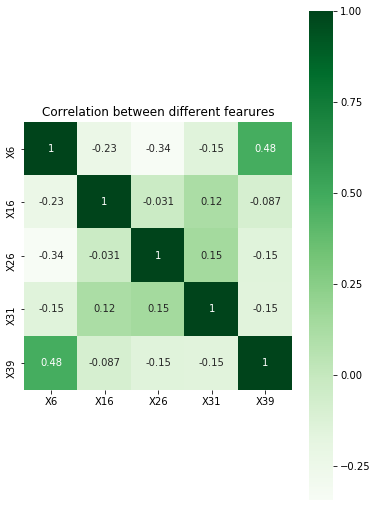

In [7]:
plt.figure(figsize=(6,9))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='Greens')
plt.title('Correlation between different fearures')
plt.show()

###  Проверка гипотезы о незначимости корреляционной матрицы

Далее согласно алгоритму, предполагая, что выборка извлечена из нормально распределенной генеральной совокупности, на уровне значимости α = 0,05 проверим гипотезу о незначимости корреляционной матрицы. 
$$H0: Rx = Е;$$
$$H1: Rx ≠ E $$

Для проверки гипотезы потребуются оценки собственных чисел корреляционной матрицы. Для воспользуемся встроенным методом np.linalg.eig

In [8]:
#проверим гипотезу о незначимости корреляционной матрицы
eigenvalues,eigenvectors=np.linalg.eig(correlation)#находим оценки собственных чисел и собственные векотры корреляционной матрицы
couple_lst=[]
for i in range(len(eigenvalues)): # список по убыванию сз с соответствующими св
    couple_lst.append((eigenvalues[i],eigenvectors[:,i]))
    
from operator import itemgetter
couple_lst = sorted(couple_lst, key = itemgetter(0),reverse=True)
#значениями оценок собственных чисел (eigenvalues), расположенных по убыванию
eigenvalues_sorted=sorted(eigenvalues,reverse=True)

 Для проверки гипотезы о незначимости матрицы   используется  критерий Уилкса.
Наблюдаемое значение:
$$ \chi^2 = -(n - \frac {2k+5}{6})ln|R_x| $$

где |𝑅̂𝑥| - определитель матрицы 𝑅̂𝑥, равный произведению оценок собственных чисел матрицы;

k – число факторов;

n – объем выборки. 

Критические значения χкр1 и 2 χкр2 определяются из уравнений: 

$$ P(\chi^2<\chi^2_{кр1}) = \frac {\alpha}{2} $$
$$ P(\chi^2>\chi^2_{кр2}) = \frac {\alpha}{2}  $$

In [9]:
import math
from scipy.stats import chi2
def chi_2(n,k,R):
    return -(n-1/6*(2*k+5))*math.log(np.linalg.det(R), math.e)

chi_2_crt=chi_2(data_cleared.shape[0],data_cleared.shape[1],correlation)
print('Наблюдаемое значение составило',chi_2_crt)
p_value=chi2.sf(chi_2_crt, data_cleared.shape[1]*(data_cleared.shape[1]-1)/2)
if p_value>0.05:
    print('Принимаем гипотезу, матрица парных коэффициентов корреляции незначима')
else:
    print('Отвергаем гипотезу, матрица парных коэффициентов корреляции значима')

Наблюдаемое значение составило 22.847808175196214
Отвергаем гипотезу, матрица парных коэффициентов корреляции значима


## 3. Доверительные интервалы


С вероятностью γ = 0,95 построим доверительные интервалы для собственных чисел.
Доверительный интервал для i-ого собственного числа λi при большом объеме выборки имеет вид:

$$ \frac {\hat \lambda_i}{1 +  u_{\frac {1+\gamma} {2}} \sqrt {\frac {2}{n-1}} } < \lambda_i < \frac {\hat \lambda_i}{1 -  u_{\frac {1+\gamma} {2}} \sqrt {\frac {2}{n-1}} } $$ 

где $ u_{\frac {1+\gamma} {2}} $ – квантиль уровня $ \frac {1+\gamma}{2} $ стандартного нормального распределения
<br>
n – объем выборки.

Для нахождения квантилей нормального распределения используем метод ss.norm.ppf (scipy.stats.norm.ppf)

In [10]:
def eigenval_left(l,n):
    return l/(1+ss.norm.ppf(0.975)*math.sqrt(2/(n-1))) #находим нижнюю границу интервала

def eigenval_right(l,n):
    return l/(1-ss.norm.ppf(0.975)*math.sqrt(2/(n-1))) #находим верхнюю границу интервала

conf_interval=np.empty((5, 3)) # создание матрицы для каждого из значений интервала и соответствующего ему собственного числа
for i in range(conf_interval.shape[0]):
    conf_interval[i,0]=eigenval_left(eigenvalues_sorted[i],data_cleared.shape[0])
    conf_interval[i,1]=eigenvalues_sorted[i]
    conf_interval[i,2]=eigenval_right(eigenvalues_sorted[i],data_cleared.shape[0])
    
conf_interval_df=pd.DataFrame(
    conf_interval,
    columns=['Нижняя граница','Собственное значение','Верхняя граница'])
conf_interval_df

,Нижняя граница,Собственное значение,Верхняя граница
0,1.286850,1.812762,3.065622
1,0.731851,1.030945,1.743466
2,0.655154,0.922903,1.560753
3,0.567416,0.799309,1.351738
4,0.308148,0.434082,0.734091


Оценим уровень информативности первых двух главных компонент составляет:

$$I_m(z(x^*)) = \frac {\lambda_1+\lambda_2+...+\lambda_m}{k} $$

In [11]:
pc=2 # кол-во главных компонент
lmbd=0
for i in range(pc):
    lmbd=lmbd+eigenvalues_sorted[i]

I = lmbd*100/f_len

print ('I(z) = {:.3f}%'.format(I))

I(z) = 56.874%


## 3.Критерии о достаточности главных компонент

### Критерия Кайзера

 Количество главных компонент можно посчитать с помощью Критерия Кайзера (отбираются факторы с собственными числами > 1)

In [12]:
if len(eigenvalues[eigenvalues > 1])>=2:
    print('Гипотеза о достаточности двух главных компонент принимается')
else:
    print('Гипотеза о достаточности двух главных компонент не принимается')
    

Гипотеза о достаточности двух главных компонент принимается


### Критерий каменистой осыпи

Для той же цели можно использовать критерий каменистой осыпи

In [13]:
#матрица дисперсий, чтоб на графике отметить
dispersion=np.empty(len(eigenvalues))
for i in range(dispersion.shape[0]):
    dispersion[i]=eigenvalues_sorted[i]/eigenvalues.sum()

In [14]:
sum_lmbd=eigenvalues.sum()
dft = pd.DataFrame([])
dft['y'] = eigenvalues_sorted #собственные значения в порядке убывания
dft['x'] = list(range(1,6))
dft['Tot_var'] = (dft['y']/sum_lmbd).apply(lambda x: round(x * 100, 2)).apply(str) + '%' #относительный вклад каждой 
#главной компоненты в суммарную дисперсию
dft

,y,x,Tot_var
0,1.812762,1,36.26%
1,1.030945,2,20.62%
2,0.922903,3,18.46%
3,0.799309,4,15.99%
4,0.434082,5,8.68%


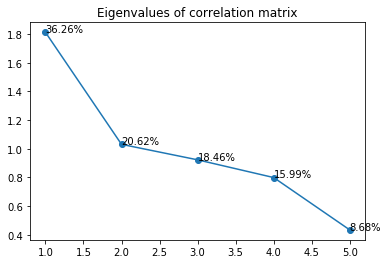

In [15]:
plt.figure(figsize=(6,4))
plt.plot(dft['x'], dft['y'], marker='o')
ax = plt.gca()
dft.apply(lambda x: ax.annotate(x['Tot_var'], (x['x'], x['y'])), axis=1);
plt.title('Eigenvalues of correlation matrix')
plt.show()

Следует найти такое место на графике, где убывание собственных значений слева направо максимально замедляется. Предполагается, что справа от этой точки находится только "факториальная осыпь".

Таким образом, число выделенных факторов не должно превышать количество факторов слева от этой точки.  

### Вклады главных компонент в суммарную дисперсию исходных признаков

In [16]:
cumlt_dispersion =[0,0,0,0,0]
cur=0
for i in range(len(features)):
    cur=cur+dispersion[i]
    cumlt_dispersion[i]=cur



In [17]:
cumlt=[0,0,0,0,0] 
cur=0
for i in range(len(features)):
    cur=cur+eigenvalues_sorted[i]
    cumlt[i]=cur


In [18]:
d=np.array([eigenvalues_sorted,dispersion,cumlt,cumlt_dispersion]).T
s=pd.DataFrame(
    data=d,
    columns=['eig','variance','cumlt_eig','cumlt_variance'])
s

,eig,variance,cumlt_eig,cumlt_variance
0,1.812762,0.362552,1.812762,0.362552
1,1.030945,0.206189,2.843706,0.568741
2,0.922903,0.184581,3.766609,0.753322
3,0.799309,0.159862,4.565918,0.913184
4,0.434082,0.086816,5.000000,1.000000


где <b>eig</b> -  оценки собственных значений <br>
<b>variance</b> - относительный вклад каждой главной компоненты в суммарную дисперсию <br>
<b>cumlt_eig</b> - накопленные значения собственных чисел <br>
<b>cumlt_variance</b> - накопленный относительный вклад

## 4.Непосредственное построение главных компонент 

Известно, что собственные векторы, соответствующие разным собственным числам, ортогональны. 
Таким образом будут выполнены требования некоррелированности главных компонент.

Следовательно, дисперсия второй главной компоненты будет равна  , а вектор   будет найден как собственный вектор матрицы  , соответствующий собственному числу.

Таким образом, можно построить k главных компонент.


In [19]:
u=np.empty((f_len,f_len))
for i in range(f_len):
    u[i]=couple_lst[i][1] #достаем главные компоненты(собственные векторы корреляционной матрицы) из матрицы couple_list
    
u=pd.DataFrame(
    data=u.T,
    columns=['Factor_' + str(i + 1) for i in range(f_len)],
    index=features)
u # eigenvectors of correlation matrix

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
X6,-0.617404,0.021257,0.278372,-0.078207,0.731268
X16,0.263889,0.816461,-0.031998,0.442570,0.258578
X26,0.406582,-0.559501,0.198944,0.600773,0.348056
X31,0.322871,0.136458,0.873342,-0.323602,-0.098433
X39,-0.528792,0.035754,0.345225,0.576515,-0.517254


In [20]:
u=u.iloc[:, :pc]
u

,Factor_1,Factor_2
X6,-0.617404,0.021257
X16,0.263889,0.816461
X26,0.406582,-0.559501
X31,0.322871,0.136458
X39,-0.528792,0.035754


### Матрица нагрузок

Матрица нагрузок главных компонент на исходные признаки является важной характеристикой, позволяющей дать интерпретацию главным компонентам.
 
Если исходные признаки центировано-нормированные, то элементы матрицы нагрузок  :
1.	 определяют степень тесноты парной линейной связи между   и   (парный коэффициент корреляции);
2.	 удельный вес влияния  -ой главной компоненты на признак  

Она определяется следующим образом: 
$$A = U^T\lambda^\frac{1}{2}$$

In [21]:
sqrt_l=np.eye(pc)
for i in range(pc):
    sqrt_l[i][i]=math.sqrt(eigenvalues_sorted[i])
A=np.dot(u,sqrt_l)
pd.DataFrame(
    data=A,
    columns=['Factor_' + str(i + 1) for i in range(pc)],
    index=features)

,Factor_1,Factor_2
X6,-0.831265,0.021583
X16,0.355297,0.828997
X26,0.547417,-0.568092
X31,0.434710,0.138553
X39,-0.711959,0.036303


### Матрица индивидуальных значений главных компонент

$$ X^T = AF^T $$

Если m=k $$ F^T = A^{-1}X^T $$
В общем случае m<=k 

$$ A^TX^T = (A^TA)F^T $$

$$ F^T = (A^TA)^{-1}A^TX^T $$

In [22]:
F=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),scaled_data.T)
result=pd.DataFrame(
    F.T,
    index=scaled_data.index, 
    columns=['z' + str(i + 1) for i in range(pc)]
)
result=result.sort_values('z1', ascending=False)
result

z1        z2
NaN Абдулинский        2.977793  2.715836
    Ясненский          1.763854 -2.211303
    Кувандыкский       1.569323  0.484849
    Новосергиевский    1.241054  1.739967
    Новоорский         1.142591 -0.278934
    Матвеевский        1.099459 -0.670531
    Асекеевский        1.079398 -0.556684
    Соль-Илецкий       0.913334 -0.941123
    Сорочинский        0.811007 -0.961225
    Переволоцкий       0.735252  1.330932
    Гайский            0.723546 -2.459759
    Кваркенский        0.668929  0.528286
    Саракташский       0.635444 -0.060319
    Илекский           0.505641  0.510367
    Пономаревский      0.482463  0.090326
    Бузулукский        0.379629  0.937303
    Северный           0.370313  0.469371
    Бугурусланский     0.278618 -0.226430
    г.Медногорск       0.240927  0.816534
    Домбаровский       0.232822 -0.921726
    Адамовский         0.021747 -1.219944
    Светлинский       -0.039922  0.077024
    Красногвардейский -0.109620 -1.044116
    Октябрьский       -0.132823 -0.393941
    Первомайский      -0.133100 -0.753433
    г.Орск            -0.135778  0.478812
    Сакмарский        -0.154187 -0.495933
    Александровский   -0.252092  0.365569
    г.Новотроицк      -0.269783  0.886632
    Ташлинский        -0.284754 -0.797708
    Грачевский        -0.325156  0.366418
    г.Абдулино        -0.348698 -0.352047
    Шарлыкский        -0.381428 -0.646185
    Акбулакский       -0.393166 -0.660222
    Беляевский        -0.437929 -0.373126
    Тюльганский       -0.721134 -0.908814
    Оренбургский      -0.722929 -0.356973
    г.Оренбург        -0.770517  2.557331
    г.Гай             -0.883496  0.361815
    г.Бугуруслан      -1.043310  1.011080
    г.Сорочинск       -1.054609 -0.260100
    г.Кувандык        -1.056118 -0.362088
    Курманаевский     -1.093412  0.972090
    г.Соль-Илецк      -1.171533  0.240650
    г.Бузулук         -1.365853  0.417787
    г.Ясный           -1.953001  0.376576
    Тоцкий            -2.638797  0.177105

In [23]:
path = "result.xlsx"
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')
sheet_name = 'result'

#запись членов кластеров в файл result на лист с именем result
#файл создается в той же директории, где лежит ноутбук с кодом
result.to_excel(writer, sheet_name=sheet_name)